# CXR segmentation using convolutional neural networks
first let us import the relevant libraries:

In [1]:
import os
import glob
import cv2
import numpy as np
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next we shall perform some preprocessing. In addition to the usual preprocessing of reading the images into numpy arrays, I normalized the grayscale images from a range of [0,255] to the range [-1,1]

In [2]:
def preprocess(basepath = '',):

    datapath = os.path.join(basepath, 'data')
    input_dir = os.path.join(datapath, 'img128')

    # Loading the images (jpg's) into an array:
    img_list=np.empty([240,128,128,1])
    for filename in glob.glob(os.path.join(input_dir, '*.jpg')):
        basename = os.path.basename(filename)  
        index = int(basename[3:6])
        img_list[index,:,:,0]=cv2.imread(filename,0)  
    # Scaling img_list to [-1,1]:
    img_list_scaled = (img_list-128)/128
    
    label_list=np.empty([240,5,128,128])

    ht_idx = 0
    lc_idx = 1
    rc_idx = 2
    ll_idx = 3
    rl_idx = 4
    
    # Reading the binary images (png's) into label array: 
    for filename in glob.glob(os.path.join(input_dir, '*.png')):
        basename = os.path.basename(filename)    
        index = int(basename[2:5])

        if basename[0:2]=='ht':
            label_list[index,ht_idx,:,:]=cv2.imread(filename,0)
        elif basename[0:2]=='lc':
            label_list[index,lc_idx,:,:]=cv2.imread(filename,0)
        elif basename[0:2]=='rc':
            label_list[index,rc_idx,:,:]=cv2.imread(filename,0)    
        elif basename[0:2]=='ll':
            label_list[index,ll_idx,:,:]=cv2.imread(filename,0)    
        elif basename[0:2]=='rl':
            label_list[index,rl_idx,:,:]=cv2.imread(filename,0)  
        else:
            print('found unknown')   

    # merging left and right calvicles:
    label_list[:,1,:,:]=label_list[:,1,:,:]+label_list[:,2,:,:]
    # merging left and right lungs:
    label_list[:,2,:,:]=label_list[:,3,:,:]+label_list[:,4,:,:]
    # Axis 3 is background:
    heart_calvicle = cv2.bitwise_or(label_list[:,0,:,:],label_list[:,1,:,:])
    not_bgd = cv2.bitwise_or(heart_calvicle,label_list[:,2,:,:])
    label_list[:,3,:,:] = 255 - not_bgd
    # removing unnecessary axes:
    label_list=label_list[:,0:4,:,:]      

    # Moving channel (label) dimension to last:
    labels = np.moveaxis(label_list,1,-1)
    # changing labels values from {0,255} to {0,1}
    labels = labels/255
    
    x = img_list_scaled
    y = labels
    print('x shape:',x.shape)
    print('y shape:',y.shape)    
    return x, y

x, y = preprocess()

x shape: (240, 128, 128, 1)
y shape: (240, 128, 128, 4)


So we are using 240 CXR images, with 4 segmentations for each image. image size is 128x128 (originally JSRT database had larger images, but we downsampled for speed).

Next we split data to test and train:

In [3]:
#splitting test train 10%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state = 1)
print('y_train shape:', y_train.shape)
print('X_train shape:', X_train.shape)
print('y_test shape:', y_test.shape)
print('X_test shape:', X_test.shape)

y_train shape: (216, 128, 128, 4)
X_train shape: (216, 128, 128, 1)
y_test shape: (24, 128, 128, 4)
X_test shape: (24, 128, 128, 1)


Now lets look at some of the images with their corresponding segmentations:

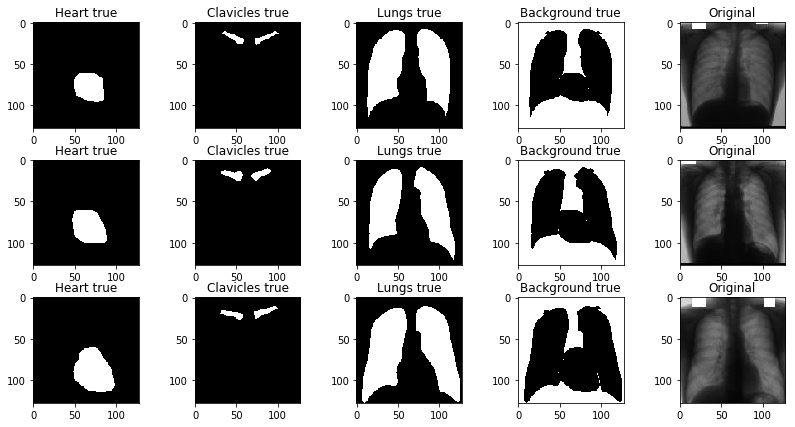

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7
n=3
f, axarr = plt.subplots(n, 5)
for i in range(n):
    axarr[i,0].imshow(y_test[i,:,:,0],cmap='gray')
    axarr[i,0].set_title('Heart true')

    axarr[i,1].imshow(y_test[i,:,:,1],cmap='gray')
    axarr[i,1].set_title('Clavicles true')

    axarr[i,2].imshow(y_test[i,:,:,2],cmap='gray')
    axarr[i,2].set_title('Lungs true')

    axarr[i,3].imshow(y_test[i,:,:,3],cmap='gray')
    axarr[i,3].set_title('Background true')

    axarr[i,4].imshow(X_test[i,:,:,0],cmap='gray')
    axarr[i,4].set_title('Original')

    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.3)

Since we are given segmentations of the clavicles and the heart in addition to the lungs, we shall perform a segmentation for each class, and also segmentation of background.

Next we define the neural network as a keras model:

In [15]:
def get_net(num_classes=4, input_shape=(128,128,1),lr=1e-3,drop_percentile=0.3):   

    inputs = Input(input_shape,)

    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    drop1 = Dropout(drop_percentile)(conv1)
    conv2 = Conv2D(32, (5, 5), padding="same", activation="relu")(drop1)
    drop2 = Dropout(drop_percentile)(conv2)
    conv3 = Conv2D(64, (7, 7), padding="same", activation="relu")(drop2)
    drop3 = Dropout(drop_percentile)(conv3)
    conv4 = Conv2D(64, (7, 7), padding="same", activation="relu")(drop3)
    drop4 = Dropout(drop_percentile)(conv4)
    conv5 = Conv2D(64, (9, 9), padding="same", activation="relu")(drop4)
    drop5 = Dropout(drop_percentile)(conv5)

    classif = Conv2D(num_classes, (3, 3), padding="same", activation="relu")(drop5)
    activation = Activation('sigmoid', name='activation')(classif)

    model = Model(inputs=inputs, outputs=activation)
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = get_net()

Now we can train the model.

But in order to find the best hyperparamters, I plotted the validation accuracy for different values of each parameter, through the epochs. 

For example, for finding the optimal learning rate, through 10 epochs, trying out 7 different learning rates:

In [6]:
learning_rates_str = []
learning_rates = []
val_acc = []
for i in range(7):
    lr = 10**-i
    learning_rates_str.append(str(lr))
    learning_rates.append(lr)
    model = get_net(lr=lr)
    epochs = 10
    batch_size = 1
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    his = history.history
    val_acc_i = his['val_acc']
    val_acc.append(val_acc_i) 

Train on 216 samples, validate on 24 samples
Epoch 1/10
216/216 [==============================] - 43s 201ms/step - loss: 2.0878 - acc: 0.7976 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 2/10
216/216 [==============================] - 15s 71ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 3/10
216/216 [==============================] - 15s 71ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 4/10
216/216 [==============================] - 15s 71ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 5/10
216/216 [==============================] - 15s 71ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 6/10
216/216 [==============================] - 15s 71ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 7/10
216/216 [==============================] - 15s 72ms/step - loss: 2.0932 - acc: 0.7984 - val_loss: 2.2365 - val_acc: 0.7801
Epoch 8/10
216/2

216/216 [==============================] - 16s 72ms/step - loss: 0.6065 - acc: 0.9139 - val_loss: 1.1475 - val_acc: 0.7661
Train on 216 samples, validate on 24 samples
Epoch 1/10
216/216 [==============================] - 17s 77ms/step - loss: 0.6948 - acc: 0.5886 - val_loss: 0.6931 - val_acc: 0.7566
Epoch 2/10
216/216 [==============================] - 16s 72ms/step - loss: 0.6905 - acc: 0.7553 - val_loss: 0.6890 - val_acc: 0.7778
Epoch 3/10
216/216 [==============================] - 16s 72ms/step - loss: 0.6825 - acc: 0.7846 - val_loss: 0.6846 - val_acc: 0.7781
Epoch 4/10
216/216 [==============================] - 16s 72ms/step - loss: 0.6784 - acc: 0.7909 - val_loss: 0.6821 - val_acc: 0.7798
Epoch 5/10
216/216 [==============================] - 16s 72ms/step - loss: 0.6756 - acc: 0.7930 - val_loss: 0.6799 - val_acc: 0.7800
Epoch 6/10
216/216 [==============================] - 16s 72ms/step - loss: 0.6730 - acc: 0.7940 - val_loss: 0.6782 - val_acc: 0.7800
Epoch 7/10
216/216 [========

And now to plot the graphs:

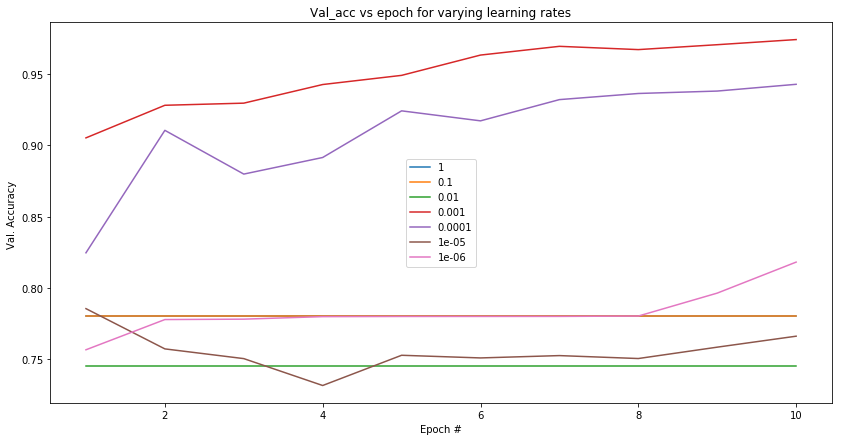

In [7]:
epochs = [x+1 for x in range(10)]
for i in range(7):
    plt.plot(epochs,val_acc[i])
plt.xlabel('Epoch #')
plt.ylabel('Val. Accuracy ')
plt.title('Val_acc vs epoch for varying learning rates')
plt.legend(learning_rates_str)

And so we see that a learning rate of lr=1e-3 is optimal.

Of course the same can be done to find optimal drop percentile and batch size.

Next we can train the model:

In [14]:
model = get_net()

In [16]:
epochs = 70
batch_size = 1
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test)
)

Train on 216 samples, validate on 24 samples
Epoch 1/70
216/216 [==============================] - 17s 79ms/step - loss: 0.6407 - acc: 0.8654 - val_loss: 0.6032 - val_acc: 0.9198
Epoch 2/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5957 - acc: 0.9229 - val_loss: 0.5827 - val_acc: 0.9305
Epoch 3/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5780 - acc: 0.9367 - val_loss: 0.5774 - val_acc: 0.9335
Epoch 4/70
216/216 [==============================] - 16s 72ms/step - loss: 0.5694 - acc: 0.9467 - val_loss: 0.5791 - val_acc: 0.9358
Epoch 5/70
216/216 [==============================] - 16s 72ms/step - loss: 0.5680 - acc: 0.9481 - val_loss: 0.5612 - val_acc: 0.9543
Epoch 6/70
216/216 [==============================] - 16s 72ms/step - loss: 0.5647 - acc: 0.9537 - val_loss: 0.5643 - val_acc: 0.9514
Epoch 7/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5578 - acc: 0.9614 - val_loss: 0.5597 - val_acc: 0.9613
Epoch 8/70
216/21

216/216 [==============================] - 15s 72ms/step - loss: 0.5340 - acc: 0.9849 - val_loss: 0.5432 - val_acc: 0.9806
Epoch 62/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5331 - acc: 0.9856 - val_loss: 0.5407 - val_acc: 0.9831
Epoch 63/70
216/216 [==============================] - 16s 72ms/step - loss: 0.5346 - acc: 0.9846 - val_loss: 0.5398 - val_acc: 0.9831
Epoch 64/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5341 - acc: 0.9849 - val_loss: 0.5455 - val_acc: 0.9785
Epoch 65/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5340 - acc: 0.9850 - val_loss: 0.5401 - val_acc: 0.9821
Epoch 66/70
216/216 [==============================] - 16s 72ms/step - loss: 0.5349 - acc: 0.9845 - val_loss: 0.5410 - val_acc: 0.9818
Epoch 67/70
216/216 [==============================] - 15s 72ms/step - loss: 0.5337 - acc: 0.9852 - val_loss: 0.5412 - val_acc: 0.9815
Epoch 68/70
216/216 [==============================] - 16s 72ms/ste

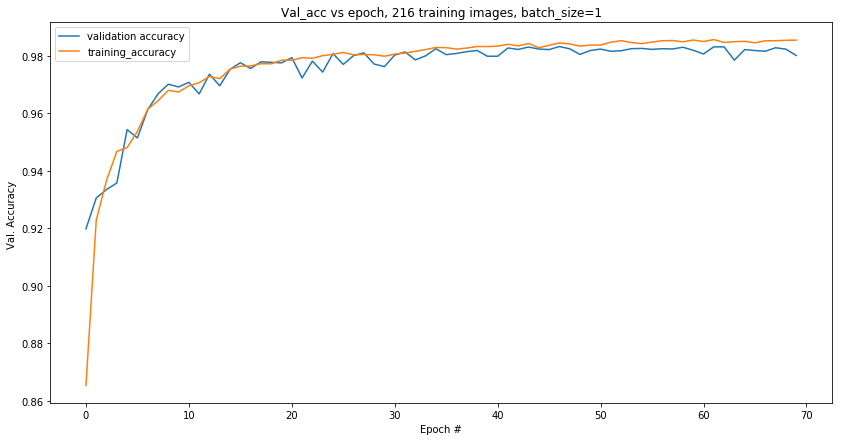

In [17]:
his = history.history
x = list(range(epochs))
y_1 = his['val_acc']
y_2 = his['acc']
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.xlabel('Epoch #')
plt.ylabel('Val. Accuracy ')
plt.title('Val_acc vs epoch, 216 training images, batch_size=1')
plt.legend(['validation accuracy','training_accuracy'])

We can see here that after about 20 epochs there is little improvement on the data.

Next we can visualize the results and compare to ground truth data:

In [18]:
y_hat = model.predict(X_test,batch_size=1)

y_hat is an array of probabilities, so next we transform it to binary labels:

In [19]:
y_pred = np.zeros(y_hat.shape)
y_pred[y_hat>0.5]=1

Segmentation of image # 0


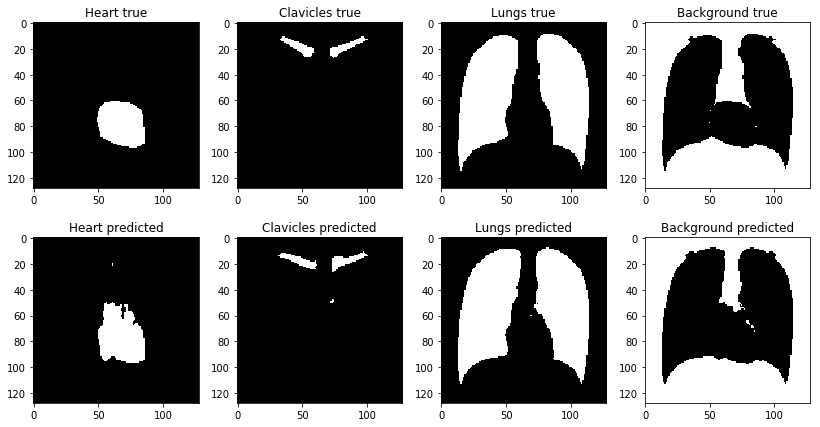

In [20]:
i=0
print('Segmentation of image #',i)
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(y_test[i,:,:,0],cmap='gray')
axarr[0, 0].set_title('Heart true')
axarr[1, 0].imshow(y_pred[i,:,:,0],cmap='gray')
axarr[1, 0].set_title('Heart predicted')

axarr[0, 1].imshow(y_test[i,:,:,1],cmap='gray')
axarr[0, 1].set_title('Clavicles true')
axarr[1, 1].imshow(y_pred[i,:,:,1],cmap='gray')
axarr[1, 1].set_title('Clavicles predicted')

axarr[0, 2].imshow(y_test[i,:,:,2],cmap='gray')
axarr[0, 2].set_title('Lungs true')
axarr[1, 2].imshow(y_pred[i,:,:,2],cmap='gray')
axarr[1, 2].set_title('Lungs predicted')

axarr[0, 3].imshow(y_test[i,:,:,3],cmap='gray')
axarr[0, 3].set_title('Background true')
axarr[1, 3].imshow(y_pred[i,:,:,3],cmap='gray')
axarr[1, 3].set_title('Background predicted')
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

Now lets calculate the Jaccard index for the segmentation of the lungs:

In [21]:
def Jaccard(mask,GTmask):
    TP = cv2.bitwise_and(mask, GTmask) #true positive
    F = cv2.bitwise_xor(mask, GTmask) #false positive and false negative
    return np.count_nonzero(TP)/(np.count_nonzero(F)+np.count_nonzero(TP))

In [24]:
Jvec=[]
for i in range(y_hat.shape[0]):
    J = Jaccard(y_pred[i,:,:,2],y_test[i,:,:,2])
    Jvec.append(J)

Javg = np.mean(Jvec)
print(f'Average Jaccard index over all {y_hat.shape[0]} test images is {Javg}')

Average Jaccard index over all 24 test images is 0.950443012654503
